# How to train and test DQN model class

In [14]:
#!pip install gymnasium[atari]
#!pip install gymnasium[accept-rom-license]
#!pip install "gym[accept-rom-license, atari]"
#!pip install PyVirtualDisplay

In [15]:
from DQN.DQN_model import DQNmodel
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from PIL import Image
import time

In [20]:
model_type = "vanilla"
model_details = "_avoid_finish_10000_update"

model_path = f"./{model_type}_DQN/model{model_details}"
checkpoint_dir = f"./{model_type}_DQN/checkpoints{model_details}"

DQNmodel = DQNmodel(
                    load_model_from=model_path,
                    checkpoint_dir=checkpoint_dir,
                    env_path="ALE/MsPacman-v5",
                    dqn_type= model_type
                )

DQNmodel.evaluate(total_episodes=100)

TypeError: 'DQNmodel' object is not callable

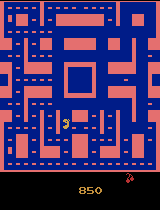

KeyboardInterrupt: 

In [19]:
# Create a virtual display
display = Display(visible=0, size=(1200, 1200))
display.start()

n_env = DQNmodel.n_env

data = {i: [[]] for i in range(n_env)}
lives = {i: 0 for i in range(n_env)}

obs = DQNmodel.restart_env()

while True:
    actions = DQNmodel.predict(obs)
    obs, rewards, dones, infos = DQNmodel.env_step(actions)
    
    for i in range(n_env):
        if lives[i] < 3:
            if lives[i] >= len(data[i]):
                data[i].append([])
            
            data[i][lives[i]].append(rewards[i])

            if 'episode' in infos[i]:
                data[i].append([infos[i]['episode']['r'],
                                infos[i]['episode']['l'],
                                infos[i]['episode']['t']
                                ])
            if dones[i]:
                lives[i] += 1

    # Render the environment and display the frame
    screen = DQNmodel.render_env()
    # Convert the RGB array to an image
    screen = Image.fromarray(screen)

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(screen)
    
    # Wait time to watch the game 
    time.sleep(1/4)  # Delay for 1/30 seconds to achieve ~30 fps

    if all([lives[i] >= 3 for i in range(n_env)]):
        break

ipythondisplay.clear_output(wait=True)
DQNmodel.close()

In [23]:
import copy
from pprint import pprint

copy_data = copy.deepcopy(data)

episodes = 3

for i in range(n_env):
    for j in range(episodes):
        copy_data[i][j] = [sum(copy_data[i][j]), len(copy_data[i][j])]

pprint(copy_data)

for i in range(n_env):
    print("Total sub-episodes for CPU", i, ":", episodes)
    print("Total reward :", sum([copy_data[i][j][0] for j in range(episodes)]), "with average reward", format(sum([copy_data[i][j][0] for j in range(episodes)])/episodes, '.2f'))
    print('Total points :', copy_data[i][-1][0])
    print('Total len :', copy_data[i][-1][1])
    print('Total time :', copy_data[i][-1][2])
    print("Total steps :", sum([copy_data[i][j][1] for j in range(episodes)]), "with average steps", format(sum([copy_data[i][j][1] for j in range(episodes)])/episodes, '.2f'))
    print("Weighted average reward :", format(sum([copy_data[i][j][0]*copy_data[i][j][1] for j in range(episodes)])/sum([copy_data[i][j][1] for j in range(episodes)]), '.2f'))
    print()

print("General results")
print("Total sub-episodes:", sum([episodes for i in range(n_env)]))
print("Average reward :", format(sum([sum([copy_data[i][j][0] for j in range(episodes)]) for i in range(n_env)])/sum([episodes for i in range(n_env)]), '.2f'))
print("Average points :", format(sum([copy_data[i][-1][0] for i in range(n_env)])/n_env, '.2f'))
print("Average len :", format(sum([copy_data[i][-1][1] for i in range(n_env)])/n_env, '.2f'))
print("Average time :", format(sum([copy_data[i][-1][2] for i in range(n_env)])/n_env, '.2f'))
print("Average steps :", format(sum([sum([copy_data[i][j][1] for j in range(episodes)]) for i in range(n_env)])/sum([episodes for i in range(n_env)]), '.2f'))
print("Weighted average reward :", format(sum([sum([copy_data[i][j][0]*copy_data[i][j][1] for j in range(episodes)]) for i in range(n_env)])/sum([sum([copy_data[i][j][1] for j in range(episodes)]) for i in range(n_env)]), '.2f'))

{0: [[19.0, 45], [49.0, 69], [10.0, 36], [1110.0, 619, 14.482316]],
 1: [[44.0, 78], [12.0, 28], [7.0, 37], [950.0, 583, 13.721981]],
 2: [[42.0, 72], [10.0, 28], [9.0, 40], [960.0, 579, 13.285053]],
 3: [[38.0, 93], [7.0, 40], [9.0, 26], [640.0, 645, 14.540972]],
 4: [[23.0, 46], [36.0, 84], [0.0, 15], [670.0, 605, 13.222186]],
 5: [[72.0, 120], [29.0, 76], [5.0, 33], [1780.0, 929, 19.304583]],
 6: [[60.0, 168], [9.0, 52], [27.0, 77], [1390.0, 1219, 24.03506]],
 7: [[22.0, 52], [41.0, 64], [10.0, 75], [1130.0, 775, 16.068201]],
 8: [[17.0, 41], [46.0, 83], [13.0, 34], [1580.0, 651, 13.431969]]}
Total sub-episodes for CPU 0 : 3
Total reward : 78.0 with average reward 26.00
Total points : 1110.0
Total len : 619
Total time : 14.482316
Total steps : 150 with average steps 50.00
Weighted average reward : 30.64

Total sub-episodes for CPU 1 : 3
Total reward : 63.0 with average reward 21.00
Total points : 950.0
Total len : 583
Total time : 13.721981
Total steps : 143 with average steps 47.67